### Jump to <a id="contents">

#### [1. Import packages](#import)
#### [2. Introduction to the N170](#intro)
#### [3. Connecting to EEG device](#connect)
#### [4. Running the experiment](#runexp)
#### [5. Loading data](#load)
#### [6. Visualizing the power spectrum](#spect_vis)
#### [7. Filtering the signal](#filt)
#### [8. Epoching](#epoch)
#### [9. Data analysis](#analysis)
#### [10. Decoding the N170](#decode)

----------

### Import packages <a id="import">

In [25]:
from muselsl import view
from mne import Epochs, find_events
import utils
from stimulus_presentation import n170

from multiprocessing import Process
from time import time, strftime, gmtime
from collections import OrderedDict

import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [64]:
matplotlib.rcParams["figure.figsize"] = [15, 10]

---------------

#### [BACK](#contents)

### Introduction to the N170 <a id="intro">

<img style="height: 300px; float: right" src="https://www.researchgate.net/profile/Vincent_Walsh3/publication/49833438/figure/fig1/AS:394279194251295@1471014893499/The-P1-and-N170-ERP-components-The-graph-shows-the-grand-average-ERP-responses-from-ten.png"/>

The N170 is a large negative event-related potential (ERP) component that occurs after the detection of faces, but not objects, scrambled faces, or other body parts such as hands. The N170 occurs around 170ms after face perception and is most easily detected at lateral posterior electrodes such as T5 and T6 [1](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.601.6917&rep=rep1&type=pdf). Frontal or profile views of human (and animal [2](https://www.ncbi.nlm.nih.gov/pubmed/14995895)) faces elicit the strongest N170 and the strength of the N170 does not seem to be influenced by how familiar a face is. Thus, although there is no consensus on the specific source of the N170, researchers believe it is related to activity in the fusiform face area, an area of the brain that shows a similar response pattern and is involved in encoding the holistic representation of a face (i.e eyes, nose mouth all arranged in the appropriate way).

In this notebook, we will attempt to detect the N170 with the Muse headband using faces and houses as our stimuli. The Muse's temporal electrodes (TP9 and TP10) are well positioned to detect the N170 and we expect we'll be able to see an N170 emerge from just a few dozen trials. We will then run several different classification algorithms on our data in order to evaluate the performance of a potential brain-computer interface using the N170.

------------

#### [BACK](#contents)

### Connecting to EEG device <a id="connect">

```>>> muselsl stream -a 00:55:DA:B5:85:4C```

```>>> muselsl record -d 60 -f ./<file_name>.csv```

Looking for an EEG stream...
Start acquiring data.


<IPython.core.display.Javascript object>


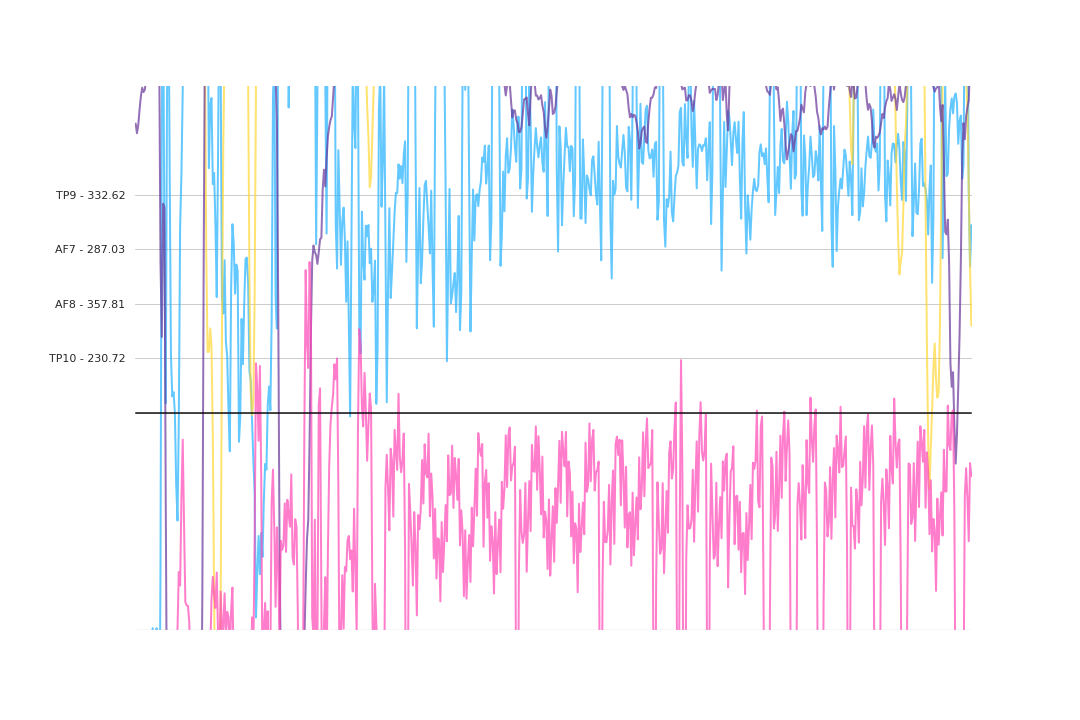

In [4]:
view(version=1, backend="nbAgg", figure='15x10')

------------

#### [BACK](#contents)

### Running the experiment <a id="runexp">

Instructions for the subject:

#### 1. Seat steadily in front of the screen
#### 2. Try to move your head and eyes as little as possible
#### 3. Focus on the presented pictures, mentally noting whether you see a house or a face

In [4]:
duration = 120
subject = 1
session = 1

In [6]:
recording_path = f"data/N170_{subject}_{session}"

In [7]:
stimulus = Process(target=n170.present, args=(duration,))
recording = Process(target=record, args=(duration, recording_path))

In [8]:
stimulus.start()
recording.start()

Looking for a EEG stream...
Started acquiring data.
Looking for a Markers stream...
Start recording at time t=1601504935.662
Time correction:  -4.056950092490297e-05
36.8355 	WARNING 	User requested fullscreen with size [1600  900], but screen is actually [1920, 1080]. Using actual size
Time correction:  -2.3384500309475698e-05
Done - wrote file: data/N170_1_1.


-------------

#### [BACK](#contents)

### Loading data <a id="load">

In [66]:
raw = utils.load_data(f"data/N170_{subject}_{session}.csv", sfreq=256.0)

Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.


In [67]:
rec_df = pd.DataFrame(raw.get_data().T, columns=raw.ch_names)

In [68]:
rec_df.head(5)

,TP9,AF7,AF8,TP10,Stim
0,0.000010,-0.000057,-0.000253,-0.000055,0.0
1,0.000021,-0.000049,-0.000225,-0.000047,0.0
2,-0.000047,-0.000052,-0.000172,-0.000032,0.0
3,-0.000101,-0.000070,-0.000196,-0.000034,0.0
4,-0.000072,-0.000127,-0.000361,-0.000047,0.0


In [69]:
rec_df["Stim"].value_counts()

0.0    30456
2.0       61
1.0       47
Name: Stim, dtype: int64

In [70]:
print("Stimulus frequency: {}%".format(round(rec_df["Stim"].mean() * 100, 4)))

Stimulus frequency: 0.5529%


Text(0.5, 0, 'milliseconds')

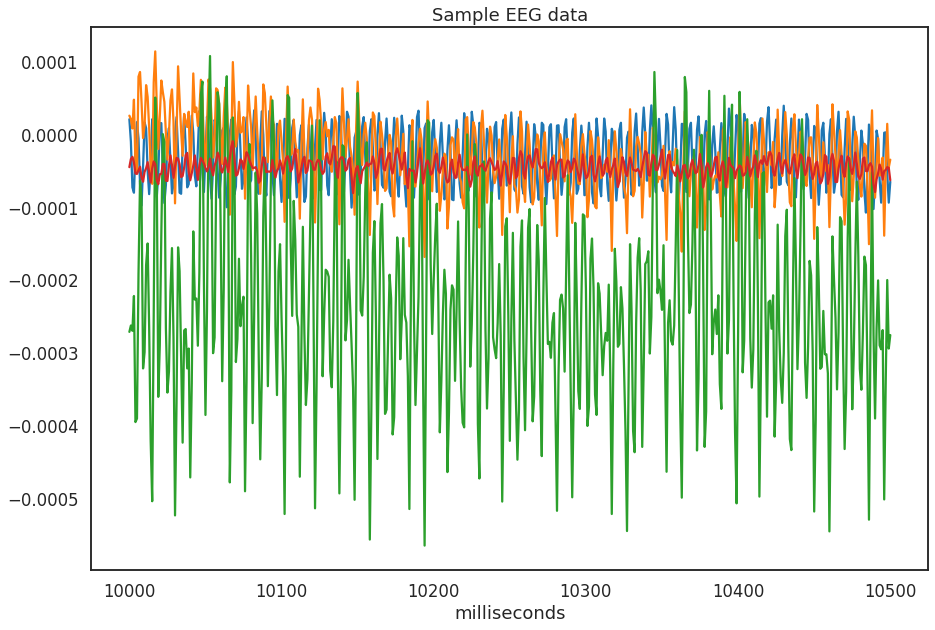

In [71]:
for c in rec_df.columns:
    if c != "Stim":
        plt.plot(rec_df.loc[10000:10500, c])
        
plt.title("Sample EEG data")
plt.xlabel("milliseconds")

------------

#### [BACK](#contents)

### Visualizing the Power Spectrum <a id="spect_vis">

Effective window size : 8.000 (s)


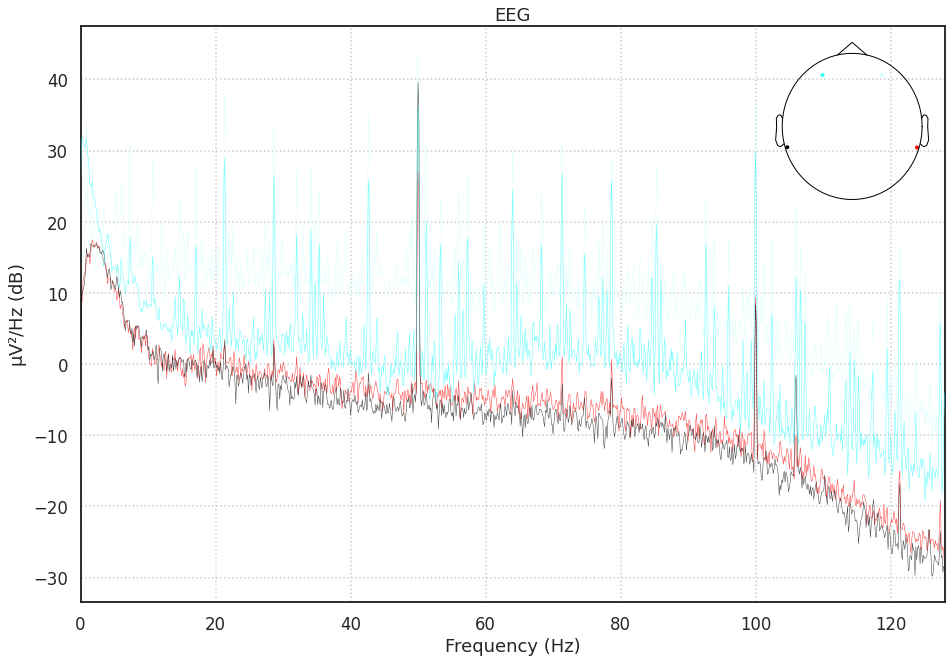

In [72]:
raw.plot_psd()

This PSD looks good. There is a large peak at 50hz, representing background electrical activity.

---------------

#### [BACK](#contents)

### Filtering the signal <a id="filt">

In [73]:
passband = (1, 30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz
Using filter length: 30564

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 30.00 Hz: -6.02, -6.02 dB

Effective window size : 8.000 (s)


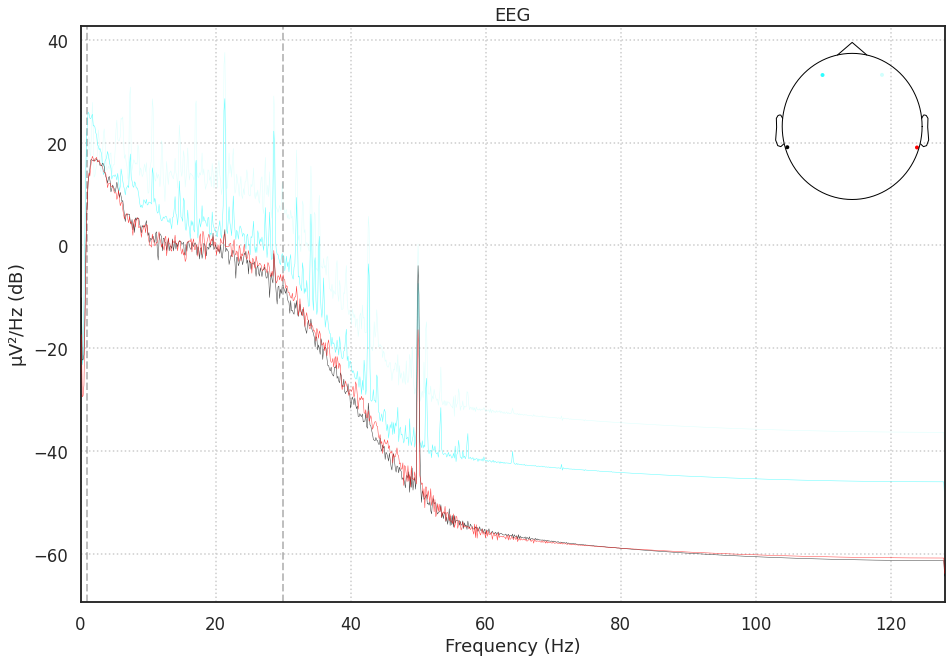

In [74]:
raw.filter(*passband, method="iir")
raw.plot_psd()

----------------

#### [BACK](#contents)

### Epoching <a id="epoch">

In [75]:
before_stim = -0.1
after_stim = 0.8
reject_amp = 75e-6

In [76]:
events = find_events(raw)
event_id = {"House": 1, "Face": 2}

108 events found
Event IDs: [1 2]


In [77]:
epochs = Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=before_stim,
    tmax=after_stim,
    baseline=None,
    #reject={"eeg": reject_amp},
    preload=True,
    verbose=False,
    picks=[0, 1, 2, 3],
)

In [78]:
print("sample drop %: ", (1 - len(epochs.events) / len(events)) * 100)

sample drop %:  0.92592592592593


------------

#### [BACK](#contents)

### Data analysis <a id="analysis">

In [61]:
X = epochs.get_data() * 1e6
times = epochs.times
y = pd.Series(epochs.events[:, -1])

In [62]:
cond_dict = {
    1: {"name": "house", "color": "black"},
    2: {"name": "face", "color": "orange"},
}

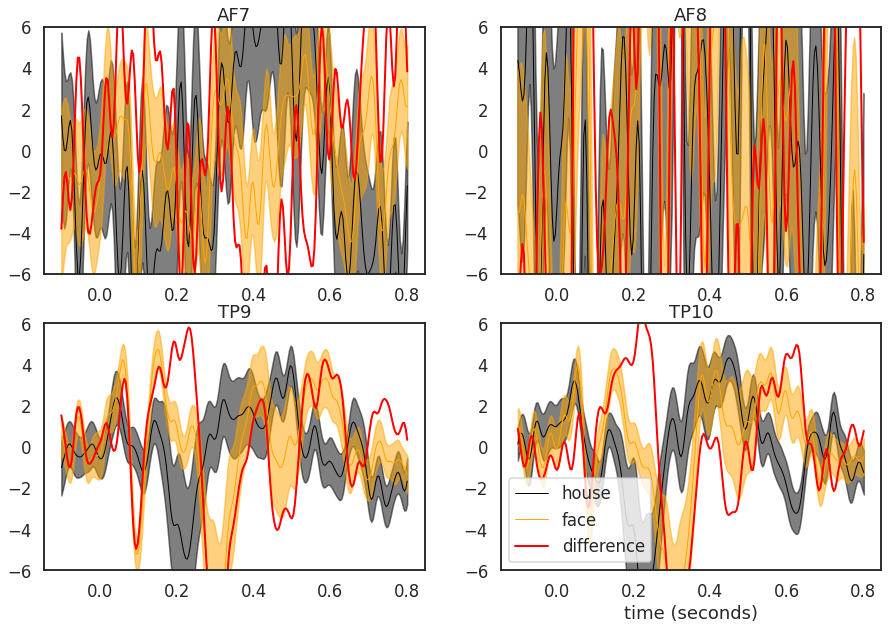

In [65]:
fig, axes = plt.subplots(2, 2)
axes = [axes[1, 0], axes[0, 0], axes[0, 1], axes[1, 1]]

for n, ch in enumerate(epochs.ch_names):
    for cond in cond_dict.keys():

        x = X[y == cond, n, :].mean(axis=0)
        std = X[y == cond, n, :].std(axis=0)
        n_sqrt = X[y == cond, n, :].shape[0] ** 0.5

        axes[n].plot(
            times,
            x,
            label=cond_dict[cond]["name"],
            c=cond_dict[cond]["color"],
            linewidth=1,
        )
        axes[n].fill_between(
            times,
            (x - std / n_sqrt),
            (x + std / n_sqrt),
            color=cond_dict[cond]["color"],
            alpha=0.5,
        )

    axes[n].plot(
        times,
        X[y == 2, n, :].mean(axis=0) - X[y == 1, n, :].mean(axis=0),
        label="difference",
        c="red",
        linewidth=2,
    )
    axes[n].set_title(ch)
    axes[n].set_ylim(-6, 6)

plt.xlabel("time (seconds)")
plt.legend()

-------------

#### [BACK](#contents)

### Decoding the N170 <a id="decode">

Next, we will use 4 different machine learning pipelines to classify the N170 based on the data we collected. The 

- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered the standard decoding pipeline for MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very commonly used in P300 BCIs. It can outperform the previous one but become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

*Note: because we're doing machine learning here, the following cell may take a while to complete*

In [ ]:
from mne.decoding import Vectorizer

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

import seaborn as sns

In [ ]:
clfs = OrderedDict()

clfs["Vect + LR"] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs["Vect + RegLDA"] = make_pipeline(
    Vectorizer(), LDA(shrinkage="auto", solver="eigen")
)
clfs["ERPCov + TS"] = make_pipeline(
    ERPCovariances(estimator="oas"), TangentSpace(), LogisticRegression()
)
clfs["ERPCov + MDM"] = make_pipeline(ERPCovariances(estimator="oas"), MDM())
clfs["XdawnCov + TS"] = make_pipeline(
    XdawnCovariances(estimator="oas"), TangentSpace(), LogisticRegression()
)
clfs["XdawnCov + MDM"] = make_pipeline(XdawnCovariances(estimator="oas"), MDM())

In [ ]:
# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

In [ ]:
# define cross validation
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, random_state=42)

In [26]:
# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:

        res = cross_val_score(clfs[m], X, y == 2, scoring="roc_auc", cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m] * len(res))
    except:
        pass

Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


In [ ]:
results = pd.DataFrame(data=auc, columns=["AUC"])
results["Method"] = methods

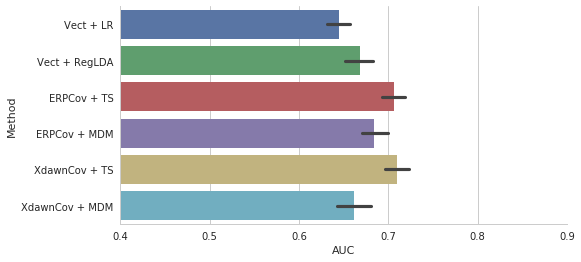

In [27]:
fig = plt.figure(figsize=[8, 4])
sns.barplot(data=results, x="AUC", y="Method")
plt.xlim(0.4, 0.9)
sns.despine()

The best classifiers for this data set appear to be the ERPCov and XdawnCov with tangent space projection pipelines. AUC is around .7, which is good, but on the low end for being able to run a brain-computer interface.